In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from pathlib import Path

import sys
current_dir = Path.cwd()
repo_root = current_dir.parent.parent  # Go up 1 levels
pdpo_path = str(repo_root.absolute())
# Add repository root to path
sys.path.insert(0, pdpo_path)

print(sys.path)



['/work/Sebas/PDPO_jax', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python313.zip', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/lib-dynload', '', '/work/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages']


In [2]:
# test_interpolation.ipynb

# Cell 1: Setup and Imports
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx

# Import our interpolation functions
from pdpo.spline.interpolation import unstack_pytree, cubic_interp,linear_interpolation_states,linear_interp
from pdpo.models.nn import create_mlp

# Set random seeds for reproducibility
jax_key = jrandom.PRNGKey(42)
np.random.seed(42)

print("JAX version:", jax.__version__)


JAX version: 0.7.0


=== Test 2: MLP Parameters Interpolation ===


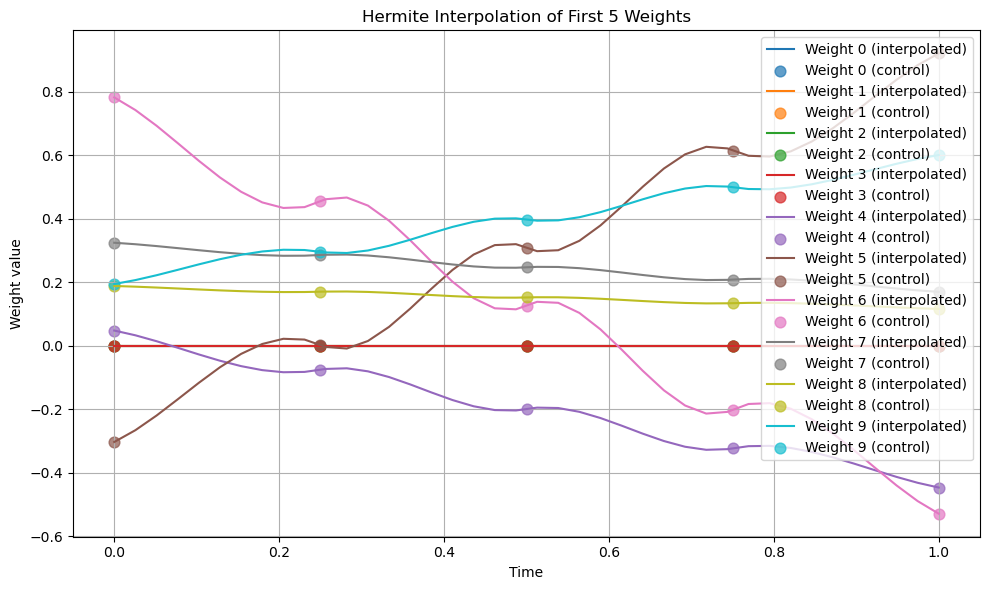

In [3]:
# Cell 3: Test 2 - MLP Parameters with Visualization
def test_mlp_parameters_interpolation():
    """Test interpolation with neural network parameters."""
    print("=== Test 2: MLP Parameters Interpolation ===")
    
    # Create MLP
    model0 = create_mlp(
        input_size=2,
        num_layers=3, 
        layer_width=4,
        activation='softplus',
        time_varying=True,
        key=jax_key
    )

    state0 = nnx.state(model0)
    key, subkey = jrandom.split(jax_key)

    model1 = create_mlp(
        input_size=2,
        num_layers=3, 
        layer_width=4,
        activation='softplus',
        time_varying=True,
        key=key
    )

    state1 = nnx.state(model1)

    t_control = jnp.linspace(0,1,5)
    
    s_query = jnp.linspace(0,1,40)
    

    initial = linear_interpolation_states(state0,state1,t_control)

    interpolation = unstack_pytree(cubic_interp(t_control,initial,s_query))

    def extract_first_k_weights(states, k=5):
        """
        Extracts the first k scalar weights from each PyTree state.
        Filters out non-array leaves (like strings).

        Args:
            states: list of PyTrees (e.g., nnx states)
            k: number of scalar weights to extract

        Returns:
            jnp.ndarray of shape [num_times, k]
        """
        flattened_series = []

        for state in states:
            flat_leaves = jax.tree.leaves(state)
            
            # Keep only JAX arrays (ignore strings, etc.)
            array_leaves = [leaf for leaf in flat_leaves if isinstance(leaf, jnp.ndarray)]

            # Flatten each array to 1D, concatenate all, and take first k scalars
            all_weights = jnp.concatenate([jnp.ravel(w) for w in array_leaves])
            flattened_series.append(all_weights[:k])

        return jnp.stack(flattened_series)  # shape [num_times, k]

    k = 10

    # Extract control and interpolated weights
    W_control = extract_first_k_weights(initial, k=k)
    W_interp = extract_first_k_weights(interpolation, k=k)

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(k):
        plt.plot(s_query, W_interp[:, i], label=f"Weight {i} (interpolated)")
        plt.scatter(t_control, W_control[:, i], s=60, marker='o', label=f"Weight {i} (control)", alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Weight value")
    plt.title("Hermite Interpolation of First 5 Weights")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    

    
    

# Run the test
test_mlp_parameters_interpolation()

# Test with trained networks

In [4]:
from pdpo.generative.models.matching_methods import FlowMatching,StochasticInterpolant
from pdpo.models.nn import create_mlp,get_activation_fn,create_mlp_time_embedding
from pdpo.data.toy_datasets import inf_train_gen
from pdpo.core.types import ModelParams, SampleArray, TimeArray
from pdpo.ode.solvers import MidpointSolver,ODESolver,sample_trajectory
from pdpo.core.types import (
    ModelParams,
    ModelState,
    TimeArray,
    SampleArray,
    VelocityArray,
    ScoreArray,
    PRNGKeyArray
)

import pickle


In [5]:
name_exp0 = 'fm_std_gaussian_to_gaussian0_final'
directory_file = pdpo_path+'/checkpoints/generative/'+name_exp0+'.pkl'
# Load the model parameters
with open(directory_file, 'rb') as f:
    model_params0 = pickle.load(f)

name_exp1 = 'fm_std_gaussian_to_gaussian1_final'
directory_file = pdpo_path+'/checkpoints/generative/'+name_exp1+'.pkl'
# Load the model parameters
with open(directory_file, 'rb') as f:
    model_params1 = pickle.load(f)    

vf = create_mlp(
    input_size= model_params0['model_config']['input_dim'],
    num_layers= model_params0['model_config']['num_layers'],
    layer_width= model_params0['model_config']['hidden_dim'],
    activation= model_params0['model_config']['activation'],
    time_varying=model_params0['model_config']['time_varying'],
    key=jax_key
)

In [6]:
state0 = model_params0['model_state']
state1 = model_params1['model_state']

bds = [state0, state1]

In [7]:
t_controls = jnp.linspace(0,1,5)
s_query = jnp.linspace(0,1,20)


In [12]:
# Linear interpolation to define control points

control_points = linear_interpolation_states(state0, state1, t_controls)



In [13]:
# Cubic interpolation 

interpolated_states = unstack_pytree(linear_interp(t_controls, control_points, s_query))

In [15]:
key = jrandom.PRNGKey(0)

key,subkey = jrandom.split(key)

batch_size = 1000

source_data = inf_train_gen(
    data_type=model_params0['data_config']['source_type'],
    key=subkey,
    batch_size=batch_size,
    dim = model_params0['data_config']['dim']
)

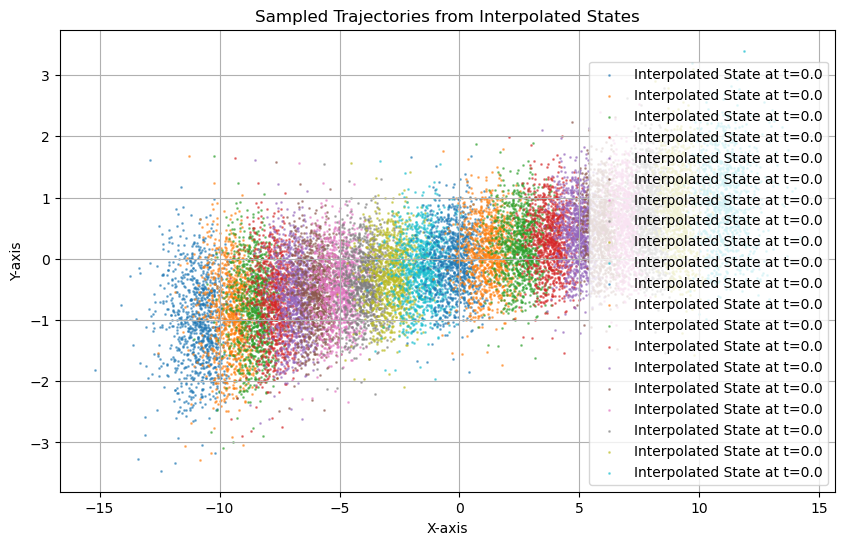

In [16]:
fig = plt.figure(figsize=(10, 6))

for parameters in interpolated_states:
    # Assign network parameters
    nnx.update(vf, parameters)
    # Sample a trajectory
    trajectory = sample_trajectory(
        vf = vf,
        x0 = source_data,
        ode_solver= MidpointSolver,
        n_steps=10
    )

    plt.scatter(trajectory[:, 0], trajectory[:, 1], s=1, alpha=0.5,label = f"Interpolated State at t={jnp.round(s_query[0],2)}")
    
plt.title("Sampled Trajectories from Interpolated States")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid()
plt.show()




In [18]:
def loss_from_control_points(control_points,t_controls, s_query, vf, source_data):
    # Get interpolated parameter states (list of pytrees)
    interpolated_states = unstack_pytree(linear_interp(t_controls, control_points, s_query))

    total_norm = 0.0
    for parameters in interpolated_states:
        # Update NN parameters
        nnx.update(vf, parameters)
        
        # Sample trajectory
        trajectory = sample_trajectory(
            vf=vf,
            x0=source_data,
            ode_solver=MidpointSolver,
            n_steps=10
        )
        
        # Norm of the trajectory
        norm_val = jnp.linalg.norm(trajectory)  
        
        total_norm += norm_val

    return total_norm

# Gradient w.r.t. control_points
grad_fn = jax.grad(loss_from_control_points)
grads = grad_fn(control_points, t_controls, s_query, vf, source_data)